# Feature Engineering and Churn Prediction for PowerCo

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Set seaborn style for plots and configure matplotlib inline
sns.set(color_codes=True, style="whitegrid")
%matplotlib inline

In [5]:
# Import Data
cleaned_data_path = 'data_for_predictions.csv'
df = pd.read_csv(cleaned_data_path)

In [6]:
# Display the first few rows to understand the data
def preview_data(data):
    print("Data Overview:")
    display(data.head())
    print("\nData Info:")
    display(data.info())

In [7]:
preview_data(df)

Data Overview:


,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,...,71,9,1,0,0,0,0,1,0,0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  14606 non-null  int64  
 1   id                                          14606 non-null  object 
 2   cons_12m                                    14606 non-null  float64
 3   cons_gas_12m                                14606 non-null  float64
 4   cons_last_month                             14606 non-null  float64
 5   forecast_cons_12m                           14606 non-null  float64
 6   forecast_discount_energy                    14606 non-null  float64
 7   forecast_meter_rent_12m                     14606 non-null  float64
 8   forecast_price_energy_off_peak              14606 non-null  float64
 9   forecast_price_energy_peak                  14606 non-null  float64
 10

None

In [8]:
#  Handle Missing Values
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Unnamed: 0                                    0
id                                            0
cons_12m                                      0
cons_gas_12m                                  0
cons_last_month                               0
                                             ..
channel_lmkebamcaaclubfxadlmueccxoimlema      0
channel_usilxuppasemubllopkaafesmlibmsdf      0
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws    0
origin_up_ldkssxwpmemidmecebumciepifcamkci    0
origin_up_lxidpiddsbxsbosboudacockeimpuepw    0
Length: 64, dtype: int64


In [9]:
# Fill missing values with appropriate strategies (e.g., filling with zeros for simplicity)
df.fillna(0, inplace=True)

In [10]:
#  Remove Irrelevant or Redundant Columns
# Identify columns with only one unique value
irrelevant_columns = [col for col in df.columns if df[col].nunique() == 1]
print("\nColumns with a single unique value:", irrelevant_columns)


Columns with a single unique value: []


In [11]:
# Drop irrelevant columns
df.drop(columns=irrelevant_columns, inplace=True)

In [12]:
# Expand Existing Columns
# Extract useful features from date columns
if 'date_activ' in df.columns:
    df['activation_month'] = pd.to_datetime(df['date_activ'], errors='coerce').dt.month
    df['activation_year'] = pd.to_datetime(df['date_activ'], errors='coerce').dt.year


In [13]:
if 'date_renewal' in df.columns:
    df['renewal_month'] = pd.to_datetime(df['date_renewal'], errors='coerce').dt.month

In [14]:
# Combine Columns to Create Better Features
# Create new combined features
df['price_diff_dec_jan'] = df['forecast_price_energy_off_peak'] * (1 + df['var_year_price_off_peak_var'])
df['net_margin_per_cons'] = df['net_margin'] / (df['cons_12m'] + 1e-5)  # Avoid division by zero
df['off_peak_to_peak_ratio'] = df['forecast_price_energy_off_peak'] / (df['forecast_price_energy_peak'] + 1e-5)

In [15]:
# Verify New Features
# Display the newly created features
existing_features = ['price_diff_dec_jan', 'net_margin_per_cons', 'off_peak_to_peak_ratio']
optional_features = ['activation_month']
existing_features += [feature for feature in optional_features if feature in df.columns]
print("\nNewly Created Features:")
print(df[existing_features].head())


Newly Created Features:
   price_diff_dec_jan  net_margin_per_cons  off_peak_to_peak_ratio
0            0.114488         6.789900e+07                1.166364
1            0.145712         5.149259e+00            14571.100000
2            0.165795         2.411922e+00                1.885973
3            0.146695         7.956152e+00            14669.400000
4            0.116902         1.315955e+01                1.168708


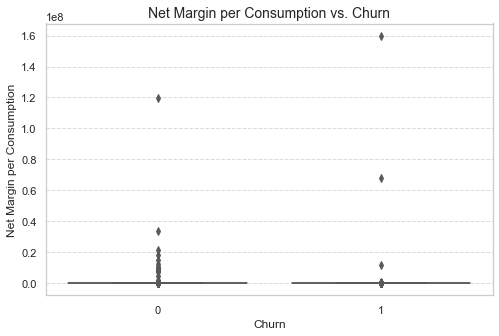

In [16]:
# Visualize relationships
plt.figure(figsize=(8, 5))
sns.boxplot(x='churn', y='net_margin_per_cons', data=df, palette='Set2')
plt.title('Net Margin per Consumption vs. Churn', fontsize=14)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Net Margin per Consumption', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

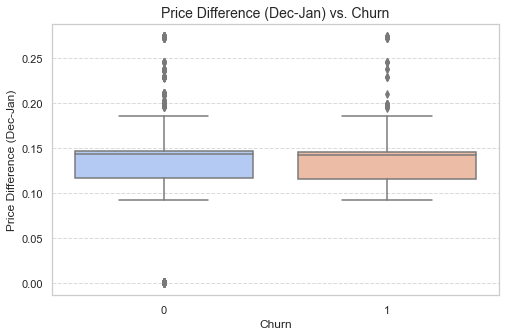

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='churn', y='price_diff_dec_jan', data=df, palette='coolwarm')
plt.title('Price Difference (Dec-Jan) vs. Churn', fontsize=14)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Price Difference (Dec-Jan)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# Prepare Data for Modeling
# Select features and target
X = df[existing_features]
y = df['churn']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Step 8: Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

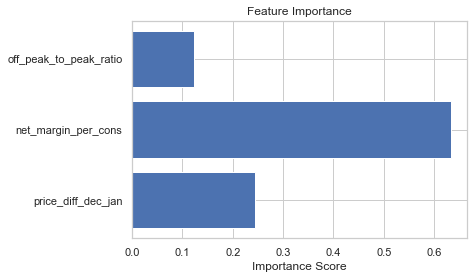

In [21]:
feature_importances = rf_model.feature_importances_
features = X.columns
plt.barh(features, feature_importances)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()

In [24]:
# Evaluate the Model
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

In [26]:
# Extract probabilities for the positive class (churn)
churn_probabilities = y_pred_proba[:, 1]

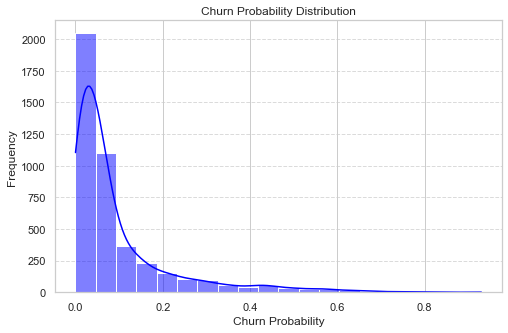

In [27]:
# Create the distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(churn_probabilities, kde=True, bins=20, color="blue")
plt.title("Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [56]:
# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3942
           1       0.18      0.04      0.06       440

    accuracy                           0.89      4382
   macro avg       0.54      0.51      0.50      4382
weighted avg       0.83      0.89      0.85      4382



In [57]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[3863   79]
 [ 423   17]]


In [58]:
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Accuracy Score: 0.8854404381560931


#### Step 10: Analysis and Discussion
#### Why did we choose these evaluation metrics?
#### - We chose accuracy to determine the percentage of correct predictions out of all predictions.
#### - The classification report includes precision, recall, and F1-score, which provide deeper insights into model performance:
####   - Precision helps to understand the ratio of true positives to all predicted positives (important for minimizing false positives).
####   - Recall gives insight into how well the model is capturing actual positives (important for minimizing false negatives).
####   - F1-score balances precision and recall, providing a single metric for performance.

#### Is the model performance satisfactory?
#### - To determine if the model performance is satisfactory, we need to look beyond accuracy. A high accuracy might be misleading if there is class imbalance.
#### - Precision and recall provide deeper insight into how well the model is capturing each class.
### - Ideally, satisfactory performance means balanced precision, recall, and a good F1-score, which indicate that the model is not biased towards one class.

In [60]:
# Save the Updated Dataset
# Save the cleaned and feature-engineered dataset
df.to_csv('cleaned_feature_engineered_data.csv', index=False)
print("\nFeature-engineered dataset saved as 'cleaned_feature_engineered_data.csv'.")


Feature-engineered dataset saved as 'cleaned_feature_engineered_data.csv'.


#### Comments and Explanations
#### - We used scikit-learn's Random Forest Classifier for its robustness and ability to handle large datasets with many features.
#### - Each step has been documented with explanations for clarity.
#### - This notebook can be shared with the AD and Estelle, presenting a complete pipeline from feature engineering to model evaluation.